# Дашборд продаж с возвратами, подготовка выгрузки данных.

[Ссылка на дашборд](https://public.tableau.com/views/RefundsbyProducts/Dashboard?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link) 

## Контекст:
У команды продукта новая квартальная задача: работа с возвратами. Чтобы вы могли вывести аналитику возвратов в дашборды, команда IT выкатила в релизе новое поле в таблице с заказами (инвойсами) -- тип заказа (type). 

Теперь там есть не только приход (income), но и возвраты (refund). При этом возвратные инвойсы – это не статус старого заказа, а новые заказы, которые дважды в неделю добавляет вручную отдел продаж и теперь в дашбордах если просто выводить сумму по выручке без фильтра по типу заказа, то каждый заказ, по которому был проведен возврат, дублируется возвратным инвойсом и у каждого инвойса свой invoice_id.

Ваша задача -- собрать дашборд, который будет показывать продактам динамику и регулярную ситуацию по возвратам в контексте общей ситуации по продуктам. 

Сумма возврата не всегда равна сумме платежа, так как в первичных оплатах мы удерживаем комиссию платежных систем, а в продлениях чаще всего возвращаем полную сумму.


**Пришлите в результате проработки темы:**

1/ Запрос или запросы, которые позволяют предобработать данные для вашей задачи с помощью SQL

2/ Информативный дашборд. Используйте доступные данные и любую систему визуализации. Мы используем Looker.

3/ Логику вашего дашборда  (можно в текстовом формате, можно в формате скринкаста): 

как продакт должен смотреть на данные 
на какие вопросы отвечают таблицы и графики 
какие ограничения данных стоит учитывать продактам, анализируя данные дашборда.

4/ Если текущих данных недостаточно, чтобы ответить на какие-то ваши вопросы, напишите запрос в IT на доработку полей в таблице заказов. 


## 1. Вводная часть (импорт библиотек и знакомство с данными)

<u>Определение продуктов / курсов</u>

**school** - школа 
    
**product** - продукт внутри школы
    
**course_id** - ID внутри курса
    
**course_title** - название курса
    
<u>Срезы дат</u>		

**paid_date** - дата оплаты
    
**invoice_created_date** - дата создания платежки, при инициации клиентом может создаваться на один заказ несколько раз в зависимости от платежной системы, также продления подписки идут под одной датой заказа. Возвратные инвойсы создаются вручную специалистами отдела продаж
    
**order_created_date** - дата регистрации заказа
    
**subscription_created_date** - дата старта подписки
    
<u>Срезы валюты / страны</u>		

**currency** - валюта оплаты
    
**payment_system** - платежная система
    
**country** - страна, из которой проведена оплата
    
<u>Срезы покупок</u>		

**paid_count** - 1 - по ивойсу проведен один платеж любого типа
    
**paid_amount** - сумма платежа в евро
    
**first_paid_count** - 1 - по инвойсу проведен один первичный платеж в подписке или платеж по единоразовым покупкам
    
**first_paid_amount** - сумма первичного платежа  в евро
    
**manual_created_count** - 1 - заказ создан вручную отделом продаж
    
**manual_created_amount** - сумма по ручному заказу  в евро
    
**extend_subscription_count** - 1 - по инвойсу проведено одно продление
    
**extend_subscription_amount** - сумма продления  в евро
    
<u>Доп параметры</u>		

**subscription_period** - количество месяцев в тарифе
    
**rank** - "очередность оплаты в подписке( 0 - единоразовая покупка без подписки, 1 - первичный платеж, 2 и т.д. - очередное продление")

**parent_invoice_id** - ID исходного платежа, который присваивается платежам типа refund для прямой связи прихода и возврата

**type** - тип инвойса


**Посмотрим на данные методами Pandas (таблица пердварительно импортирована в postgresql)**

In [18]:
# Импортируем библиотеки
import pandas as pd
import psycopg2
import seaborn as sns

In [2]:
# устанавливаем параметры соединения
con = psycopg2.connect(
            host='localhost',
            port=5432,
            database='aanalytics',
            user='postgres',
            password='Rkty,enthjk',
        )
# con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

# Определяем функцию для запуска запроса
def q(query):
    return pd.read_sql(query, con = con)

In [3]:
# Открываем датасет
df =q('select * from public.ff_sales_test')

In [4]:
display(df.sample(10))
display(df.info())
display(df.describe().T)

,invoice_id,school,product,course_id,course_title,paid_date,invoice_created_date,order_created_date,subscription_created_date,currency,...,first_paid_count,first_paid_amount,manual_created_count,manual_created_amount,extend_subscription_count,extend_subscription_amount,subscription_period,rank,parent_invoice_id,type
29205,1341612,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-19,2023-06-19,2023-03-19,2023-03-19,RUB,...,0,0.000000,0,0.0,1,8.112245,3.0,2,NaN,income
28621,1333125,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-12,2023-06-12,2023-03-12,2023-03-12,RUB,...,0,0.000000,0,0.0,1,8.112245,3.0,2,NaN,income
28739,1334552,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-13,2023-06-13,2023-03-13,2023-03-13,RUB,...,0,0.000000,0,0.0,1,8.112245,3.0,2,NaN,income
3650,1335026,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-14,2023-06-14,2023-06-13,2023-06-14,EUR,...,1,8.418367,0,0.0,0,0.000000,3.0,1,NaN,income
23069,1349498,FF,club,188,Женский клуб Я/Мы SUPER Лицо,2023-06-25,2023-06-25,2022-10-08,2022-10-25,RUB,...,0,0.000000,0,0.0,1,4.540816,1.0,9,NaN,income
6146,1373293,FF,main,148,SUPER Лицо. Перезагрузка,2023-07-17,2023-07-17,2023-07-17,2023-07-17,EUR,...,1,8.622449,0,0.0,0,0.000000,3.0,1,NaN,income
26519,1387666,FF,main,148,SUPER Лицо. Перезагрузка,2023-07-30,2023-07-30,2023-07-30,2023-07-30,RUB,...,1,15.255102,0,0.0,0,0.000000,12.0,1,NaN,income
1211,1380917,FF,main,148,SUPER Лицо. Перезагрузка,2023-07-24,2023-07-24,2023-04-24,2023-04-24,EUR,...,0,0.000000,0,0.0,1,5.051021,1.0,3,NaN,income
28333,1328653,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-08,2023-06-08,2023-03-08,2023-03-08,RUB,...,0,0.000000,0,0.0,1,8.112245,3.0,2,NaN,income
28839,1336261,FF,club,188,Женский клуб Я/Мы SUPER Лицо,2023-06-15,2023-06-15,2023-03-15,2023-03-15,RUB,...,0,0.000000,0,0.0,1,10.153061,3.0,2,NaN,income


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31521 entries, 0 to 31520
Data columns (total 24 columns):
invoice_id                    31521 non-null int64
school                        31521 non-null object
product                       31521 non-null object
course_id                     31521 non-null int64
course_title                  31521 non-null object
paid_date                     31521 non-null object
invoice_created_date          31521 non-null object
order_created_date            31521 non-null object
subscription_created_date     31521 non-null object
currency                      31521 non-null object
payment_system                31521 non-null object
country                       31521 non-null object
paid_count                    31521 non-null int64
paid_amount                   31521 non-null float64
first_paid_count              31521 non-null int64
first_paid_amount             31521 non-null float64
manual_created_count          31521 non-null int64
manual_cre

None

,count,mean,std,min,25%,50%,75%,max
invoice_id,31521.0,1.355256e+06,19944.389845,5.811370e+05,1.338472e+06,1.355712e+06,1.371681e+06,1.394394e+06
course_id,31521.0,1.590460e+02,20.296061,4.600000e+01,1.480000e+02,1.480000e+02,1.880000e+02,2.070000e+02
paid_count,31521.0,9.983503e-01,0.040584,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
paid_amount,31521.0,7.669030e+00,7.064287,5.102041e-03,5.051021e+00,7.602041e+00,9.132653e+00,6.849490e+02
first_paid_count,31521.0,5.511881e-01,0.497381,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
first_paid_amount,31521.0,4.512784e+00,7.989882,0.000000e+00,0.000000e+00,5.051021e+00,8.622449e+00,6.849490e+02
manual_created_count,31521.0,3.426287e-02,0.181907,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
manual_created_amount,31521.0,3.009562e-01,3.669334,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.081633e+02
extend_subscription_count,31521.0,4.471622e-01,0.497208,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
extend_subscription_amount,31521.0,3.144149e+00,3.811997,0.000000e+00,0.000000e+00,0.000000e+00,5.051021e+00,1.607143e+01


In [5]:
# Изучим некоторые колонки подробнее
print(df['school'].value_counts())
print()
print(df['product'].value_counts())
print()
print(df['course_title'].value_counts())
print()
print(df['type'].value_counts())
print()
print(df['rank'].value_counts())
print()
df['paid_date'] = pd.to_datetime(df['paid_date']).dt.date 
df['invoice_created_date'] = pd.to_datetime(df['invoice_created_date']).dt.date 
df['order_created_date'] = pd.to_datetime(df['order_created_date']).dt.date 
df['subscription_created_date'] = pd.to_datetime(df['subscription_created_date']).dt.date.astype('datetime64') 


print('paid_date:', df['paid_date'].min() ,'-', df['paid_date'].max())
print('invoice_created_date:', df['invoice_created_date'].min() ,'-', df['invoice_created_date'].max())
print('order_created_date:', df['order_created_date'].min() ,'-', df['order_created_date'].max())
print('subscription_created_date:', df['subscription_created_date'].min() ,'-', df['subscription_created_date'].max())
print()
print('Полных дубликатов:', df.duplicated().sum())

FF    31521
Name: school, dtype: int64

main       25143
club        6282
offline       42
online        33
muing         12
pro            6
extend         2
yoga           1
Name: product, dtype: int64

SUPER Лицо. Перезагрузка            23419
Женский клуб Я/Мы SUPER Лицо         6237
NEW SUPER Лицо                       1781
Секреты SUPER Лица                     42
SUPER Лицо PRO                         28
Мьюинг для всех                        12
Прямые эфиры c Анастасией Бурдюг        1
Super Тело: йога дома                   1
Name: course_title, dtype: int64

income    31205
refund      316
Name: type, dtype: int64

1     16978
2     10833
3      1631
4       506
0       419
5       353
6       316
7       180
8       132
9       130
10       36
11        7
Name: rank, dtype: int64

paid_date: 2023-06-01 - 2023-07-31
invoice_created_date: 2021-04-30 - 2023-08-06
order_created_date: 2021-04-30 - 2023-07-31
subscription_created_date: 2022-08-30 00:00:00 - 2023-07-31 00:00:00

По

In [6]:
df.head(5)

,invoice_id,school,product,course_id,course_title,paid_date,invoice_created_date,order_created_date,subscription_created_date,currency,...,first_paid_count,first_paid_amount,manual_created_count,manual_created_amount,extend_subscription_count,extend_subscription_amount,subscription_period,rank,parent_invoice_id,type
0,1345680,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-22,2023-06-22,2023-06-22,2023-06-22,AZN,...,1,10.0,0,0.0,0,0.0,3.0,1,NaN,income
1,1346287,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-22,2023-06-22,2023-06-22,2023-06-22,AZN,...,1,10.0,0,0.0,0,0.0,3.0,1,NaN,income
2,1347850,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-24,2023-06-24,2023-06-24,2023-06-24,AZN,...,1,10.0,0,0.0,0,0.0,3.0,1,NaN,income
3,1349259,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-25,2023-06-25,2023-06-25,2023-06-25,AZN,...,1,10.0,0,0.0,0,0.0,3.0,1,NaN,income
4,1348820,FF,main,148,SUPER Лицо. Перезагрузка,2023-06-25,2023-06-25,2023-06-25,2023-06-25,AZN,...,1,10.0,0,0.0,0,0.0,3.0,1,NaN,income


<AxesSubplot:xlabel='paid_amount'>

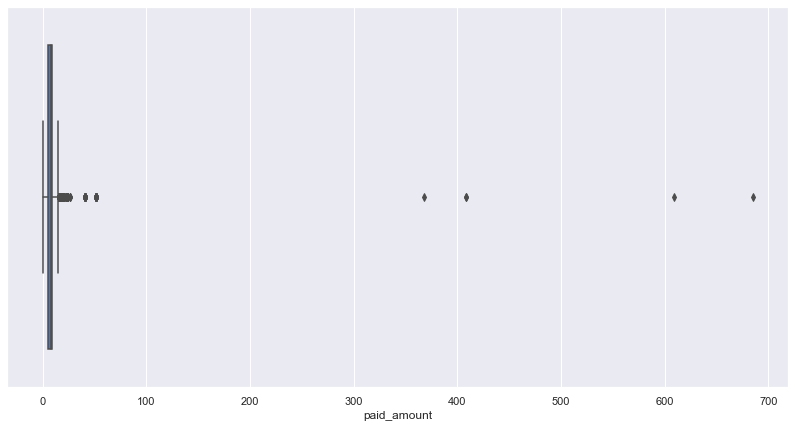

In [7]:
sns.set(rc = {'figure.figsize':(14,7)})
sns.boxplot(data= df, x='paid_amount')

* Полных явных дубликатов не обнаружено;
* Период оплат данных с 2023-06-01 - 2023-07-31;
* Даты приведены к соответствующему типу;
* Явно имеются значительные выбросы по платежам, нужно будет выяснить все по ним у продактов.

## 2. Исследовательский анализ (**далее с помощью SQL**)

Посмотрим на суммарные выручки

In [8]:
q(''' 

  SELECT 
      type,
      sum(paid_amount) all,
      sum(first_paid_amount) razovyi,
      sum(manual_created_amount) manual,
      sum (extend_subscription_amount) podpiska,
      count(1)
  FROM public.ff_sales_test  
  GROUP BY type
  ORDER BY 1
  
''') 

,type,all,razovyi,manual,podpiska,count
0,income,237364.7200,137986.050,9346.61700,99101.57,31205
1,refund,4370.8623,4270.521,139.75304,0.00,316


In [9]:
# Этот же запрос адаптированный для BIG QUERY
'''
SELECT 
    type,
    sum(paid_amount) as `all`,
    sum(first_paid_amount) `razovyi`,
    sum(manual_created_amount) `manual`,
    sum (extend_subscription_amount) `podpiska`,
    count(1)
FROM `takeclass-test.test.ff_sales_test`
GROUP BY type
ORDER BY 1
'''

'\nSELECT \n    type,\n    sum(paid_amount) as `all`,\n    sum(first_paid_amount) `razovyi`,\n    sum(manual_created_amount) `manual`,\n    sum (extend_subscription_amount) `podpiska`,\n    count(1)\nFROM `takeclass-test.test.ff_sales_test`\nGROUP BY type\nORDER BY 1\n'

На заметку: сумма всех продлений, разовых и ручных платежей не сходится с суммой по всем платежам из поля paid_amount. 

Возвратов всего около 1%.

In [10]:
q(''' 

  SELECT 
      t1.invoice_id,
      t1.country,
      t1.payment_system,
      t1.type,
      t1.product,
      t1.course_title,
      t1.paid_date,
      t1.invoice_created_date,
      t1.order_created_date,
      t1.paid_amount,
      t2.paid_amount paid_amount_ref,
      CASE 
        WHEN t1.paid_amount - COALESCE(t2.paid_amount,0) < 0 THEN 0 
        ELSE t1.paid_amount - COALESCE(t2.paid_amount,0) END paid_amount_diff,
      t1.rank,
      CASE WHEN t1.rank = 0 THEN 'Единоразовая покупка без подписки'
           WHEN t1.rank = 1 THEN 'Первичный платеж'
           WHEN t1.rank > 1 THEN 'Очередное продление'
           ELSE '' END payment_type,
      t1.currency,
      t1.subscription_period
  FROM public.ff_sales_test t1
  LEFT JOIN public.ff_sales_test t2 on t2.parent_invoice_id = t1.invoice_id 
  ORDER BY cast (t1.paid_date as date)
  
''') 

,invoice_id,country,payment_system,type,product,course_title,paid_date,invoice_created_date,order_created_date,paid_amount,paid_amount_ref,paid_amount_diff,rank,payment_type,currency,subscription_period
0,1322034,belgium,Stripe Romania,income,main,SUPER Лицо. Перезагрузка,2023-06-01,2023-06-01,2023-05-01,5.051021,NaN,5.051021,2,Очередное продление,EUR,1.0
1,1321727,poland,Cloud Sber ff-anyclass.com,income,main,SUPER Лицо. Перезагрузка,2023-06-01,2023-06-01,2023-06-01,5.051021,NaN,5.051021,1,Первичный платеж,RUB,1.0
2,1321895,france,Cloud Sber ff-anyclass.com,income,main,SUPER Лицо. Перезагрузка,2023-06-01,2023-06-01,2023-06-01,9.132653,NaN,9.132653,1,Первичный платеж,RUB,3.0
3,1321356,russia,Cloud Sber ff-anyclass.com,income,main,SUPER Лицо. Перезагрузка,2023-06-01,2023-06-01,2023-06-01,5.051021,NaN,5.051021,1,Первичный платеж,RUB,1.0
4,1321512,spain,Stripe Romania,income,main,SUPER Лицо. Перезагрузка,2023-06-01,2023-06-01,2023-05-01,5.051021,NaN,5.051021,2,Очередное продление,EUR,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31516,1389070,russia,Cloud Sber ff-anyclass.com,income,club,Женский клуб Я/Мы SUPER Лицо,2023-07-31,2023-07-31,2023-07-31,4.846939,NaN,4.846939,1,Первичный платеж,RUB,1.0
31517,1388345,kazakhstan,NEW Stripe Romania,income,club,Женский клуб Я/Мы SUPER Лицо,2023-07-31,2023-07-31,2023-07-31,4.861225,NaN,4.861225,1,Первичный платеж,KZT,1.0
31518,1388366,italy,PayPal Romania,income,main,NEW SUPER Лицо,2023-07-31,2023-07-31,2023-07-31,4.591837,NaN,4.591837,1,Первичный платеж,EUR,1.0
31519,1388216,spain,Cloud Sber ff-anyclass.com,income,club,Женский клуб Я/Мы SUPER Лицо,2023-07-31,2023-07-31,2022-12-31,4.540816,NaN,4.540816,8,Очередное продление,RUB,1.0


In [11]:
# Этот же запрос адаптированный для BIG QUERY
'''
SELECT 
  t1.invoice_id,
  t1.country,
  t1.payment_system,
  t1.type,
  t1.product,
  t1.course_title,
  t1.paid_date,
  t1.invoice_created_date,
  t1.order_created_date,
  t1.paid_amount,
  t2.paid_amount paid_amount_ref,
  CASE 
    WHEN t1.paid_amount - COALESCE(t2.paid_amount,0) < 0 THEN 0 
    ELSE t1.paid_amount - COALESCE(t2.paid_amount,0) END paid_amount_diff,
  t1.rank,
  CASE WHEN t1.rank = 0 THEN 'Единоразовая покупка без подписки'
       WHEN t1.rank = 1 THEN 'Первичный платеж'
       WHEN t1.rank > 1 THEN 'Очередное продление'
       ELSE '' END payment_type,
  t1.currency,
  t1.subscription_period
FROM `takeclass-test.test.ff_sales_test` t1
LEFT JOIN `takeclass-test.test.ff_sales_test` t2 on t2.parent_invoice_id = t1.invoice_id 
ORDER BY t1.paid_date
'''

"\nSELECT \n  t1.invoice_id,\n  t1.country,\n  t1.payment_system,\n  t1.type,\n  t1.product,\n  t1.course_title,\n  t1.paid_date,\n  t1.invoice_created_date,\n  t1.order_created_date,\n  t1.paid_amount,\n  t2.paid_amount paid_amount_ref,\n  CASE \n    WHEN t1.paid_amount - COALESCE(t2.paid_amount,0) < 0 THEN 0 \n    ELSE t1.paid_amount - COALESCE(t2.paid_amount,0) END paid_amount_diff,\n  t1.rank,\n  CASE WHEN t1.rank = 0 THEN 'Единоразовая покупка без подписки'\n       WHEN t1.rank = 1 THEN 'Первичный платеж'\n       WHEN t1.rank > 1 THEN 'Очередное продление'\n       ELSE '' END payment_type,\n  t1.currency,\n  t1.subscription_period\nFROM `takeclass-test.test.ff_sales_test` t1\nLEFT JOIN `takeclass-test.test.ff_sales_test` t2 on t2.parent_invoice_id = t1.invoice_id \nORDER BY t1.paid_date\n"


Раньше были только поступления, а теперь еще и возврат (type). Сгруппируем все платежи по категориям (страна/курс/продукт/платежная система/дата оплаты/очередность платежа) и выведем суммы и количества в % от всех и в абсолютных цифрах отдельно по поступлениям и по возвратам.

In [12]:
first_ds= q(''' 

SELECT
    i.country,
    cast(i.paid_date as date) paid_date,
    cast(r.paid_date as date) ref_paid_date,
    i.school,    
    i.subscription_period,    
    i.course_title,    
    i."rank",    
    i.payment_system,    
    i.product, 
    count(1) cnt_income,    
    sum(case when r.invoice_id is not null then 1 else 0 end) cnt_refund,    
    sum(i.paid_amount) sum_income,
    sum(case when r.invoice_id is not null then r.paid_amount else 0 end) sum_refund
FROM public.ff_sales_test i
LEFT JOIN public.ff_sales_test r ON r.parent_invoice_id = i.invoice_id 
WHERE i.type = 'income'
GROUP BY 
    i.country,
    cast(i.paid_date as date),
    cast(r.paid_date as date),
    i.school,    
    i.subscription_period,    
    i.course_title,    
    i."rank",    
    i.payment_system,    
    i.product 
    
''') 

In [13]:
# --Этот же запрос адаптированный для BIG QUERY

'''
SELECT
    i.country,
    cast(i.paid_date as date) paid_date,
    cast(r.paid_date as date) ref_paid_date,
    i.school,    
    i.subscription_period,    
    i.course_title,    
    i.`rank`,    
    i.payment_system,    
    i.product, 
    count(1) cnt_income,    
    sum(case when r.invoice_id is not null then 1 else 0 end) cnt_refund,    
    sum(i.paid_amount) sum_income,
    sum(case when r.invoice_id is not null then r.paid_amount else 0 end) sum_refund
FROM `takeclass-test.test.ff_sales_test`  i
LEFT JOIN `takeclass-test.test.ff_sales_test`  r ON r.parent_invoice_id = i.invoice_id 
WHERE i.type = 'income'
GROUP BY 
    i.country,
    cast(i.paid_date as date),
    cast(r.paid_date as date),
    i.school,    
    i.subscription_period,    
    i.course_title,    
    i.`rank`,    
    i.payment_system,    
    i.product 
'''

"\nSELECT\n    i.country,\n    cast(i.paid_date as date) paid_date,\n    cast(r.paid_date as date) ref_paid_date,\n    i.school,    \n    i.subscription_period,    \n    i.course_title,    \n    i.`rank`,    \n    i.payment_system,    \n    i.product, \n    count(1) cnt_income,    \n    sum(case when r.invoice_id is not null then 1 else 0 end) cnt_refund,    \n    sum(i.paid_amount) sum_income,\n    sum(case when r.invoice_id is not null then r.paid_amount else 0 end) sum_refund\nFROM `takeclass-test.test.ff_sales_test`  i\nLEFT JOIN `takeclass-test.test.ff_sales_test`  r ON r.parent_invoice_id = i.invoice_id \nWHERE i.type = 'income'\nGROUP BY \n    i.country,\n    cast(i.paid_date as date),\n    cast(r.paid_date as date),\n    i.school,    \n    i.subscription_period,    \n    i.course_title,    \n    i.`rank`,    \n    i.payment_system,    \n    i.product \n"

Выведем более детальную информацию только по возвратам и их родительским поступлениям, а также долю суммы возврата от всех платежей этой категории.

In [14]:
second_ds= q(''' 

SELECT
    r.invoice_id,
    r.product,   
    r.school,    
    r.subscription_created_date subscription_created_date,    
    cast(r.paid_date as date) refund_paid_date,
    cast(i.paid_date as date) income_paid_date,
    r.course_title,    
    r."rank",    
    r.country,
    i.paid_amount income_paid_amount,
    r.paid_amount refund_paid_amount,
    r.subscription_period,
    round(cast(r.paid_amount/ sum(r.paid_amount) over () *100 as numeric),3) shr
FROM public.ff_sales_test i
RIGHT JOIN public.ff_sales_test r ON r.parent_invoice_id = i.invoice_id 
WHERE r.type = 'refund'

''') 

In [15]:
# --Этот же запрос адаптированный для BIG QUERY

'''
SELECT
    r.invoice_id,
    r.product,   
    r.school,    
    r.subscription_created_date subscription_created_date,    
    cast(r.paid_date as date) refund_paid_date,
    cast(i.paid_date as date) income_paid_date,
    r.course_title,    
    r.`rank`,    
    r.country,
    i.paid_amount income_paid_amount,
    r.paid_amount refund_paid_amount,
    r.subscription_period,
    round(cast(r.paid_amount/ sum(r.paid_amount) over () *100 as numeric),3) shr
FROM `takeclass-test.test.ff_sales_test` i
RIGHT JOIN `takeclass-test.test.ff_sales_test` r ON r.parent_invoice_id = i.invoice_id 
WHERE r.type = 'refund'
'''

"\nSELECT\n    r.invoice_id,\n    r.product,   \n    r.school,    \n    r.subscription_created_date subscription_created_date,    \n    cast(r.paid_date as date) refund_paid_date,\n    cast(i.paid_date as date) income_paid_date,\n    r.course_title,    \n    r.`rank`,    \n    r.country,\n    i.paid_amount income_paid_amount,\n    r.paid_amount refund_paid_amount,\n    r.subscription_period,\n    round(cast(r.paid_amount/ sum(r.paid_amount) over () *100 as numeric),3) shr\nFROM `takeclass-test.test.ff_sales_test` i\nRIGHT JOIN `takeclass-test.test.ff_sales_test` r ON r.parent_invoice_id = i.invoice_id \nWHERE r.type = 'refund'\n"

Теперь производем выгрузку для построения дашборда.

In [16]:
# Выгружаем первый датафрэйм в файл

path = 'C:/Users/mind23/first_ds.csv'
first_ds.to_csv(path, index=False, sep=";")

In [17]:
# Выгружаем второй датафрэйм в файл

path = 'C:/Users/mind23/second_ds.csv'
second_ds.to_csv(path, index=False, sep=";")

## 3. Логика дашборда

[Ссылка на дашборд](https://public.tableau.com/views/RefundsbyProducts/Dashboard?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link) 

Дашборд с динамикой возвратов по продуктам состоит из трех секций:

* **линейные графики (1)** по динамике количества возвратов:

	1.1 динамика абсолютного количества
	1.2 в % от количества родительских поступлений

С помощью этих графиков мы можем определить общие тенденции роста и спада возвратов в определенные даты. Графики могут ограничиваться основными фильтрами дашборда **(4)**. При переключении параметра **(5)** мы увидим ту же динамику, но в контексте денежных сумм. 

* **карта мира (2) с показателями доли возвратов от поступлений** (в абсолюте и в деньгах в зависимости от выбранного параметра **(5)**).

Можно фильтровать данные по динамике выбрав на карте нужную страну, комбинируя это с основными фильтрами **(4)** и оперативно обнаруживать повышение возвратов по сравнению с другими странами/продуктами и курсами.

* **детализация подозрительных инвойсов по возвратам в табличном виде (3)** с возможностью сортировки по полям.

Выводит конкретные инвойсы по которым сумма возврата отличалась от суммы родительских поступлений.




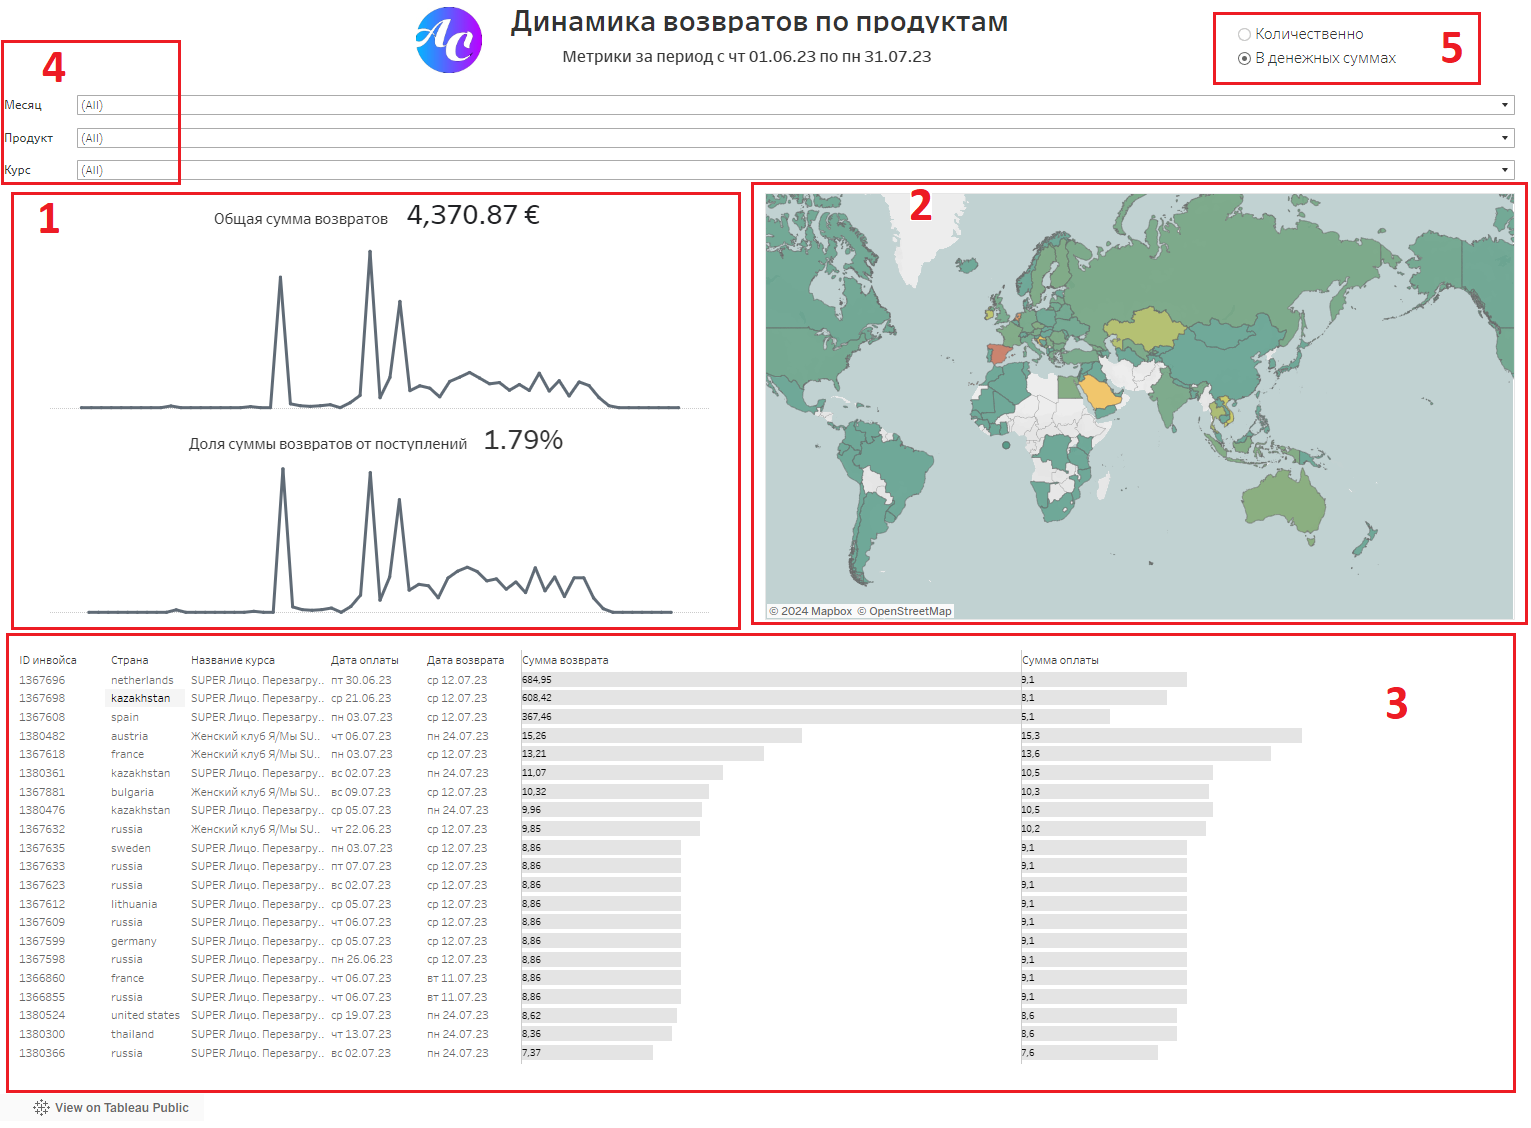

**Ограничения**

Продактам также стоит учитывать, что не все возвратные инвойсы имееют связь с родительскими платежами (на текущий момент таких 14), этот вопрос стоит отследить отдельно.

В качестве дополнительной информации, которая улучшит дашборд следует:

- запросить данные о комиссиях платежных систем, чтобы можно было посчитать точную сумму инвойсов после возвратов;
- уточнить данные о возвратах без связи с поступлениями;
- добавить в датасет причину возвратов, чтобы можно было смотреть какие проблемы нужно решать в первую очередь.